In [42]:
import torch
from collections import namedtuple
from src.data import *
from src.plotting import *

import matplotlib.pyplot as plt
import seaborn as sns

### Below is the implementation of the Kallus et al simulation

In [43]:
data = namedtuple("data","X T Y")
outcome_funcs = namedtuple("Outcome_funcs","cfounded_func uncfounded_func")

kallus_func = lambda X,U,T,eps: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*U*X+0.5*eps


cfoundeded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*(T-0.5)*X**2
uncfounded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2

kallus_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func,
              uncfounded_func=uncfounded_func)

In [44]:
X_range = (-1,1)
n_samples_exp = 120
n_samples_obs = 1000
T_prop=0.5

obs_data = get_obs_sample_kallus(n_samples_obs,X_range=(-1,1),T_prop=T_prop,outcome_func = kallus_func)
exp_data = get_exp_sample_kallus(n_samples_exp,X_range=(-1,1),T_prop=T_prop,outcome_func = kallus_func)

pseudo_outcome = (exp_data.T - T_prop)/((T_prop)*(1-T_prop))*exp_data.Y  
pseudo_data = data(X=exp_data.X, T=exp_data.T,Y=pseudo_outcome)


(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X'>],
       dtype=object))

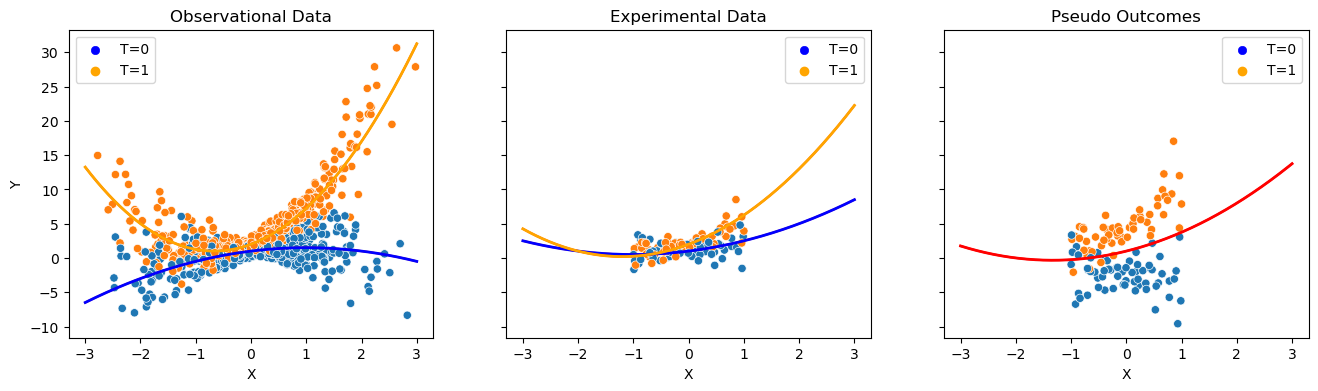

In [45]:
obs_exp_pseudo_plot(obs_data,exp_data,kallus_outcome_funcs,T_prop=0.5)

## We now implement GP bounds following https://github.com/aCapone1/gauss_proc_unknown_hyp

In [46]:
import gpytorch
from pyro.infer.mcmc import NUTS, MCMC
from gpytorch.priors import UniformPrior
import pyro
import pandas as pd
from src.GP_bounds import *
import numpy as np

In [47]:
# set upper and lower bounds for uniform hyperprior
dimx = 1
ub = 1.1*torch.ones(3)
ub[0] = 1.1
ub[-1] = 1.1
lb = 0.9*torch.ones(3)
lb[-1] = 0.9
loglikelihood0 = [None]
training_iterations = 2000
num_samples = 20
warmup_steps = 20
sqrbeta0 = 1.44

hyperparam_dict = {
    "dimx":dimx,
    "ub":ub,
    "lb":lb,
    "loglikelihood0":loglikelihood0,
    "training_iterations":training_iterations,
    "num_samples":num_samples,
    "warmup_steps":warmup_steps,
    "sqrbeta0":sqrbeta0

}

In [48]:
train_x = exp_data.X[exp_data.T==0]
train_y = exp_data.Y[exp_data.T==0]

X_plot = torch.linspace(-3, 3, 1000)
Y_plot = kallus_outcome_funcs.uncfounded_func(X_plot,0)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,_ = GP_bounds_model.bound_output(X_plot)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 40/40 [00:00, 54.78it/s, step size=3.69e+00, acc. prob=0.001]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_31026/1528558140.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")


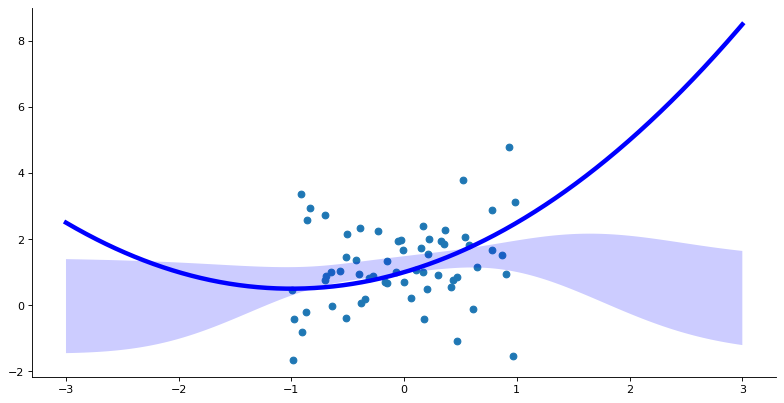

In [49]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(train_x,train_y)

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach')

## Implementing as if all functions are GP

We implement all functions as GP's to asses the benefits or failings

In [50]:
hyperparam_dict = {
    "dimx":dimx,
    "ub":ub,
    "lb":lb,
    "loglikelihood0":loglikelihood0,
    "training_iterations":training_iterations,
    "num_samples":50,
    "warmup_steps":50,
    "sqrbeta0":1.414
}
T_prop_GP = 0.5


In [51]:
cfd_GPs = [0,0]
ucfd_GPs = [0,0]

exp_data_GP_train = get_exp_sample_kallus(100,X_range=(-3,3),T_prop=T_prop,outcome_func = kallus_func)

adjusted_exp_data = adjust_data(exp_data_GP_train,kallus_outcome_funcs.cfounded_func)

for i in range(2):
    cfd_GPs[i] = GP_func_1d((-3,3),hyperparam_dict)
    ucfd_GPs[i] = GP_func_1d((-3,3),hyperparam_dict,train_data=get_conditioned_data(adjusted_exp_data,i),scale=1)
    # ucfd_GPs[i] = GP_func_1d((-3,3),hyperparam_dict,train_data=None,scale=1)

# cfded_GP_func = lambda X,T: (1-T)*cfd_GPs[0](X) + (T)*cfd_GPs[1](X)
cfded_GP_func = kallus_outcome_funcs.cfounded_func
ucfded_GP_func = lambda X,T: cfded_GP_func(X,T) + (1-T)*ucfd_GPs[0](X) + (T)*ucfd_GPs[1](X)
outcome_funcs_GP = outcome_funcs(cfounded_func=cfded_GP_func,uncfounded_func=ucfded_GP_func)

In [52]:
X_range_obs = (-3,3)
X_obs = (X_range_obs[1] - X_range_obs[0]) * torch.rand(n_samples_obs) + X_range_obs[0]
T_obs = (torch.rand(n_samples_obs) > T_prop_GP).type(torch.float)
Y_obs = cfded_GP_func(X_obs,T_obs) + torch.randn(n_samples_obs)
obs_data_GP = data(X=X_obs,Y=Y_obs,T=T_obs)

X_range_exp = (-1,1)
X_exp = (X_range_exp[1] - X_range_exp[0]) * torch.rand(n_samples_exp) + X_range_exp[0]
T_exp = (torch.rand(n_samples_exp) > T_prop_GP).type(torch.float)
Y_exp = ucfded_GP_func(X_exp,T_exp) + torch.randn(n_samples_exp)
exp_data_GP = data(X=X_exp,Y=Y_exp,T=T_exp)

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X'>],
       dtype=object))

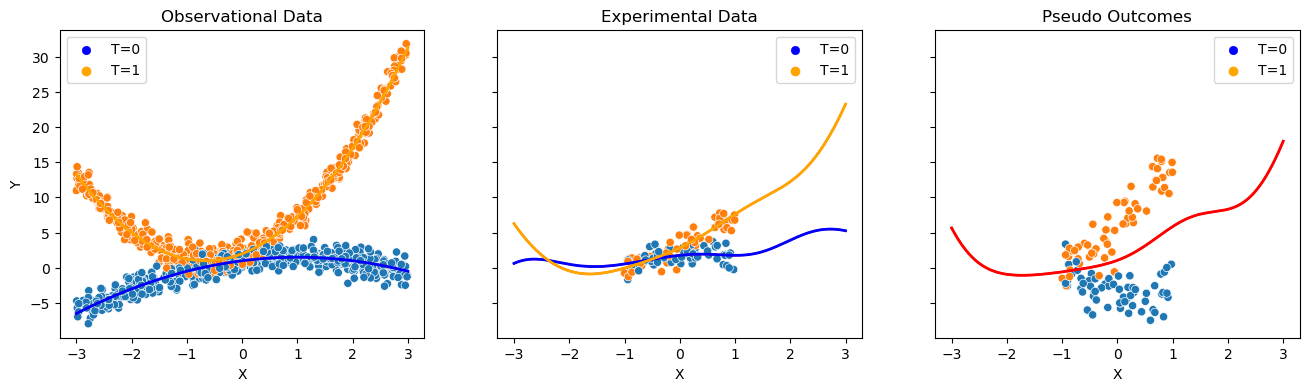

In [53]:
obs_exp_pseudo_plot(obs_data_GP,exp_data_GP,outcome_funcs_GP,T_prop=T_prop_GP)

In [54]:
train_x = exp_data_GP.X[exp_data_GP.T==0]
train_y = exp_data_GP.Y[exp_data_GP.T==0]

X_plot = torch.linspace(-3, 3, 1000)
Y_plot = outcome_funcs_GP.uncfounded_func(X_plot,0)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,_ = GP_bounds_model.bound_output(X_plot)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:01, 54.11it/s, step size=1.53e+00, acc. prob=0.681]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_31026/2803010479.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")


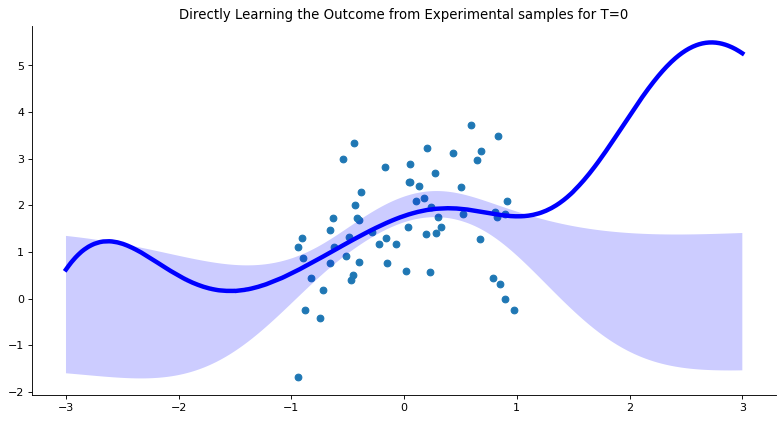

In [55]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Directly Learning the Outcome from Experimental samples for T=0")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(train_x,train_y)

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach')

In [56]:
adjusted_exp_data_GP = adjust_data(exp_data_GP,outcome_funcs_GP.cfounded_func)

train_x = adjusted_exp_data_GP.X[adjusted_exp_data_GP.T==1]
train_y = adjusted_exp_data_GP.Y[adjusted_exp_data_GP.T==1]

X_plot = torch.linspace(-3, 3, 1000)
Y_plot =  (outcome_funcs_GP.uncfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,1))

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,stdv = GP_bounds_model.bound_output(X_plot)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:02, 39.80it/s, step size=5.78e-01, acc. prob=0.926]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_31026/1894580804.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")


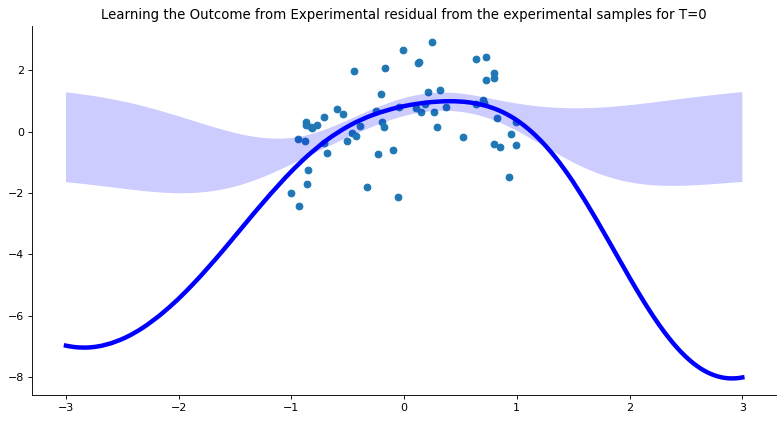

In [57]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Learning the Outcome from Experimental residual from the experimental samples for T=0")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(train_x,train_y)

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach')

In [58]:
adjusted_exp_data_GP = adjust_data(exp_data_GP,outcome_funcs_GP.cfounded_func)
pseudo_data_GP = get_pseudo_outcome_data(adjusted_exp_data_GP,T_prop=T_prop_GP)
train_x = pseudo_data_GP.X
train_y = pseudo_data_GP.Y

X_plot = torch.linspace(-3, 3, 1000)
# Y_plot = outcome_funcs_GP.uncfounded_func(X_plot,1)-outcome_funcs_GP.uncfounded_func(X_plot,0) - (outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0))

Y_plot = outcome_funcs_GP.uncfounded_func(X_plot,1)-outcome_funcs_GP.uncfounded_func(X_plot,0)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
mean_0 =  (outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0))
bounds,_,_ = GP_bounds_model.add_bounds(X_plot,mean_0,torch.zeros_like(stdv))

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:03, 27.96it/s, step size=4.21e-01, acc. prob=0.980]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_31026/235399475.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")


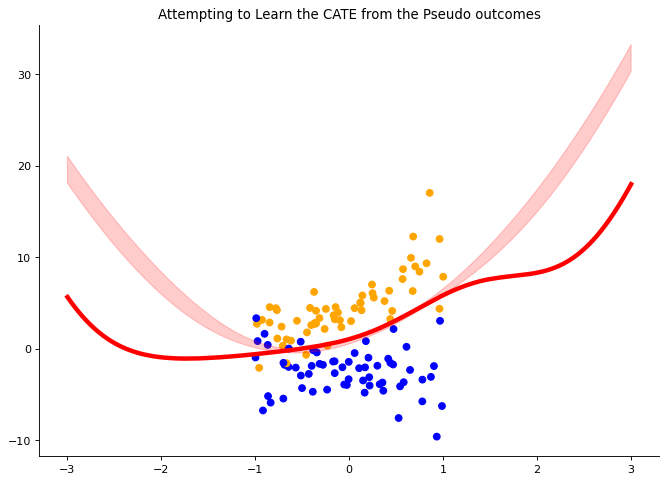

In [59]:
colors = ["blue","orange"]
pseudo_data = get_pseudo_outcome_data(exp_data,T_prop=T_prop_GP)

fig = plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Attempting to Learn the CATE from the Pseudo outcomes")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(pseudo_data.X,pseudo_data.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach',color="red")

In [60]:
train_x = adjusted_exp_data_GP.X[adjusted_exp_data_GP.T==0]
train_y = adjusted_exp_data_GP.Y[adjusted_exp_data_GP.T==0]


likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model_0 = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model_0.fit(train_x,train_y)
bounds,mean_0,stdv_0 = GP_bounds_model_0.bound_output(X_plot)

mean_0 = mean_0 - (outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0))

train_x = adjusted_exp_data_GP.X[adjusted_exp_data_GP.T==1]
train_y = adjusted_exp_data_GP.Y[adjusted_exp_data_GP.T==1]

GP_bounds_model_1 = BoundingGPModel_Unknown_Hyperparameters(deepcopy(likelihood),hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,stdv_sum = GP_bounds_model.add_bounds(X_plot,-mean_0,stdv_0)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:02, 41.06it/s, step size=1.19e+00, acc. prob=0.848]


Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:02, 41.91it/s, step size=6.40e-01, acc. prob=0.935]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_31026/3966544334.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")


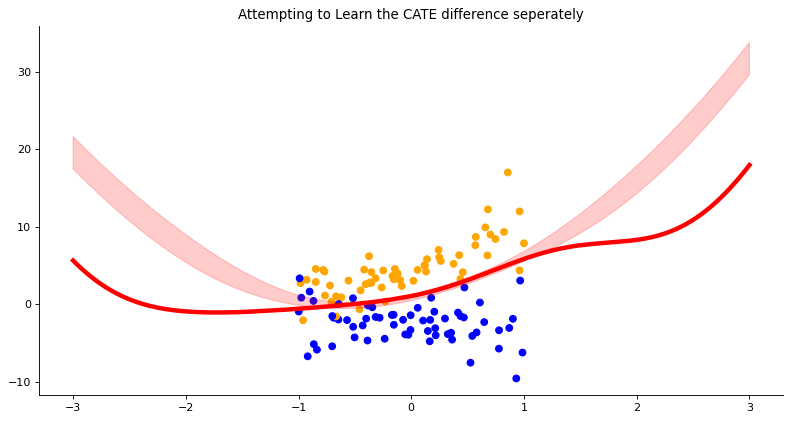

In [61]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Attempting to Learn the CATE difference seperately")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(pseudo_data.X,pseudo_data.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach',color="red")

## 